In [1]:
# import libraries

from __future__ import print_function
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Reshape, GlobalAveragePooling1D
from keras.layers import Conv2D, MaxPooling2D, Conv1D, MaxPooling1D
from keras.utils import np_utils
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn import preprocessing

Using TensorFlow backend.
C:\Users\506-3\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\506-3\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\506-3\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\506-3\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py

In [22]:
#define useful functions

def feature_normalize(dataset):

    mu = np.mean(dataset, axis=0)
    sigma = np.std(dataset, axis=0)
    return (dataset - mu)/sigma


def show_confusion_matrix(validations, predictions):

    matrix = metrics.confusion_matrix(validations, predictions)
    plt.figure(figsize=(8, 7))
    sns.heatmap(matrix,
                cmap="coolwarm",
                linecolor='white',
                linewidths=1,
                xticklabels=LABELS,
                yticklabels=LABELS,
                annot=True,
                fmt="d")
    
    plt.title("Confusion Matrix", fontsize = '20')
    plt.ylabel("True Label", fontsize = '20')
    plt.xlabel("Predicted Label", fontsize = '20')
    plt.show()


def show_basic_dataframe_info(dataframe,
                              preview_rows=20):

    """
    This function shows basic information for the given dataframe

    Args:
        dataframe: A Pandas DataFrame expected to contain data
        preview_rows: An integer value of how many rows to preview

    Returns:
        Nothing
    """

    # Shape and how many rows and columns
    print("Number of columns in the dataframe: %i" % (dataframe.shape[1]))
    print("Number of rows in the dataframe: %i\n" % (dataframe.shape[0]))
    print("First 20 rows of the dataframe:\n")
    # Show first 20 rows
    print(dataframe.head(preview_rows))
    print("\nDescription of dataframe:\n")
    # Describe dataset like mean, min, max, etc.
    # print(dataframe.describe())


def read_data(file_path):

    """
    This function reads the accelerometer data from a file

    Args:
        file_path: URL pointing to the CSV file

    Returns:
        A pandas dataframe
    """

    column_names = ['user-id',
                    'activity',
                    'timestamp',
                    'x-axis',
                    'y-axis',
                    'z-axis']
    df = pd.read_csv(file_path,
                     header=None,
                     names=column_names)
    # Last column has a ";" character which must be removed ...
    df['z-axis'].replace(regex=True,
      inplace=True,
      to_replace=r';',
      value=r'')
    # ... and then this column must be transformed to float explicitly
    df['z-axis'] = df['z-axis'].apply(convert_to_float)
    # This is very important otherwise the model will not fit and loss
    # will show up as NAN
    df.dropna(axis=0, how='any', inplace=True)

    return df


def convert_to_float(x):

    try:
        return np.float(x)
    except:
        return np.nan


# Not used right now
def feature_normalize(dataset):

    mu = np.mean(dataset, axis=0)
    sigma = np.std(dataset, axis=0)
    return (dataset - mu)/sigma

def plot_axis(ax, x, y, title):

    ax.plot(x, y)
    ax.set_title(title)
    ax.xaxis.set_visible(False)
    ax.set_ylim([min(y) - np.std(y), max(y) + np.std(y)])
    ax.set_xlim([min(x), max(x)])
    ax.grid(True)


def create_segments_and_labels(df, time_steps, step, label_name):

    """
    This function receives a dataframe and returns the reshaped segments
    of x,y,z acceleration as well as the corresponding labels

    Args:
        df: Dataframe in the expected format
        time_steps: Integer value of the length of a segment that is created
    Returns:
        reshaped_segments
        labels:
    """

    # x, y, z acceleration as features
    N_FEATURES = 1
    # Number of steps to advance in each iteration (for me, it should always
    # be equal to the time_steps in order to have no overlap between segments)
    # step = time_steps
    segments = []
    labels = []
    for i in range(0, len(df) - time_steps, step):
        xs = df['x-axis'].values[i: i + time_steps]
        # Retrieve the most often used label in this segment
        label = stats.mode(df[label_name][i: i + time_steps])[0][0]
        segments.append([xs])
        labels.append(label)

    # Bring the segments into a better shape
    reshaped_segments = np.asarray(segments, dtype= np.float32).reshape(-1, time_steps, N_FEATURES)
    labels = np.asarray(labels)

    return reshaped_segments, labels


In [3]:
# Set some standard parameters upfront
pd.options.display.float_format = '{:.1f}'.format
sns.set() # Default seaborn look and feel
plt.style.use('ggplot')
print('keras version ', keras.__version__)

LABELS = ["P1-CONTAMINATED","P2-HIGH VISCOCITY","P3-FILTER CLOG","HEALTY"]

# The number of steps within one time segment
TIME_PERIODS = 80
# The steps to take from one segment to the next; if this value is equal to
# TIME_PERIODS, then there is no overlap between the segments
STEP_DISTANCE = 40

keras version  2.2.4


In [ ]:
#load the full data and split randomly..just like in svm

In [4]:
# Load Training dataset
df_train = pd.read_csv('4pump_classes.csv')

# Describe the data
show_basic_dataframe_info(df_train, 10000) #show first 20 rows of the data

Number of columns in the dataframe: 2
Number of rows in the dataframe: 41745

First 20 rows of the dataframe:

         CONDITION  x-axis
0     contaminated    -0.6
1     contaminated    -5.8
2     contaminated    -9.4
3     contaminated   -11.9
4     contaminated   -13.8
...            ...     ...
9995  contaminated    -0.0
9996  contaminated     0.1
9997  contaminated    -0.0
9998  contaminated     0.2
9999  contaminated    -0.0

[10000 rows x 2 columns]

Description of dataframe:



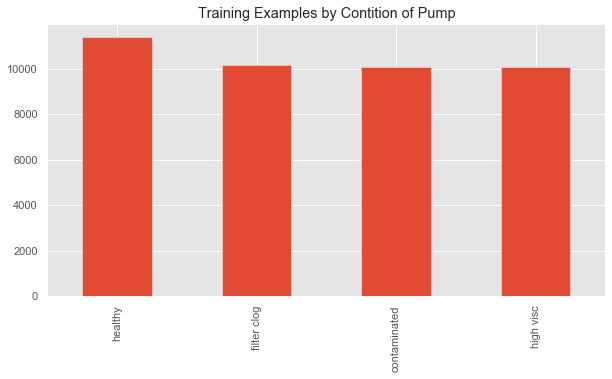

In [5]:
plt.figure(figsize=(10,5))
df_train['CONDITION'].value_counts().plot(kind='bar',title='Training Examples by Contition of Pump')
plt.show()

#a = df.drop(['CONDITION'],axis=1) # Drop columns you dont need
#a = a.values
#plt.plot(a)
#plt.show

In [6]:
# Define column name of the label vector for converting to numbers
LABEL = "CONDITION"
# Transform the labels from String to Integer via LabelEncoder
le = preprocessing.LabelEncoder()
# Add a new column to the existing DataFrame with the encoded values
df_train[LABEL] = le.fit_transform(df_train["CONDITION"].values.ravel())
df_train
#df_train[:40000]

#CONTAMINATED = 0
#FILTER CLOG  = 1
#HEALTHY      = 2
#HIGH VISC    = 3

,CONDITION,x-axis
0,0,-0.6
1,0,-5.8
2,0,-9.4
3,0,-11.9
4,0,-13.8
...,...,...
41740,2,-0.1
41741,2,0.1
41742,2,-0.0
41743,2,0.1


In [7]:
# Normalize features for training data set
df_train['x-axis'] = feature_normalize(df_train['x-axis'])


,CONDITION,x-axis
0,0,-0.2
1,0,-2.4
2,0,-3.8
3,0,-4.9
4,0,-5.7
...,...,...
41740,2,-0.0
41741,2,0.0
41742,2,-0.0
41743,2,0.0


In [8]:
df_train = df_train.round({'x-axis': 6})
# Reshape the training data into segments so that they can be processed by the network
x_train, y_train = create_segments_and_labels(df_train, TIME_PERIODS,STEP_DISTANCE,LABEL) 

#x_train, returns (m-examples x time periods x 3[x,y,z])
#y_train returns corresponding labels for each  m-examples (1,2, ...,6)

# Inspect x data
print('x_train shape is: ', x_train.shape)
# Displays (20869, 40, 3)
print(x_train.shape[0], 'training samples')
# Displays 20869 train samples

# Inspect y data
print('y_train shape is: ', y_train.shape)
# Displays (20869,)

# Set input & output dimensions
num_time_periods, num_sensors = x_train.shape[1], x_train.shape[2] #number oF time periods and number and sensors (x,y,z)
num_classes = le.classes_.size
print(list(le.classes_))


x_train shape is:  (1042, 80, 1)
1042 training samples
y_train shape is:  (1042,)
['contaminated', 'filter clog', 'healthy', 'high visc']


In [9]:
# Set input_shape / reshape for Keras
# Remark: acceleration data is concatenated in one array in order to feed
# it properly into coreml later, the preferred matrix of shape [40,3]
# cannot be read in with the current version of coreml (see also reshape
# layer as the first layer in the keras model)
input_shape = (num_time_periods*num_sensors)  
x_train = x_train.reshape(x_train.shape[0], input_shape) #it took the no of rows by the no of time periods

#take not! in the cas of only one signal vector (only xaxis)
#the input shape becomes 'num_time_periods * 1!

print('x_train shape:', x_train.shape)
# x_train shape: (20869, 120)
print('input_shape:', input_shape)
# input_shape: (120)

# Convert type for Keras otherwise Keras cannot process the data
x_train = x_train.astype("float32")
y_train = y_train.astype("float32")

x_train shape: (1042, 80)
input_shape: 80


In [10]:
# One-hot encoding of y_train labels (only execute once!)
# reshape y_train to be in the form (m-training examples x no of classes)
#this will ensure that that the output of the NN would yield the no. of output classses

y_train = np_utils.to_categorical(y_train, num_classes)
print('New y_train shape: ', y_train.shape)
# should look like (m-trainig examples, no of classes)

New y_train shape:  (1042, 4)


In [11]:
#lets keep track of our inputs to the 1D CNN
print('lets keep in mind that the time periods as input shape is: ', TIME_PERIODS)
print('lets keep in mind that the number of input features/XYZ sensors is: ', num_sensors)
print('#######################################################')
# 1D CNN neural network
model_m = Sequential()
model_m.add(Reshape((TIME_PERIODS, num_sensors), input_shape=(input_shape,)))  #input layer with "input_shape" nodes
#in the above layer, we use the time period as the input shape (80)

model_m.add(Conv1D(100, 10, activation='relu', input_shape=(TIME_PERIODS, num_sensors)))
model_m.add(Conv1D(100, 10, activation='relu'))

model_m.add(MaxPooling1D(3)) 
# this simply impluies that the pooling/scaling size is 3
#with this in our minds, the output would be (output of preceeding layer/ 3 = 62/3= 20)

model_m.add(Conv1D(160, 10, activation='relu'))
model_m.add(Conv1D(160, 10, activation='relu'))

model_m.add(GlobalAveragePooling1D())
#this layer has a scaling of 2. thast is (output of last laer/2 = 1...as seen in the resut below)

model_m.add(Dropout(0.5))
#this layer "drops out" half(0.5) of the outputs with minimal relevance/importance

model_m.add(Dense(num_classes, activation='softmax'))
#this is the output layer with fully connected layers
#no. of output nodes is equal to no of output classes

print(model_m.summary())

lets keep in mind that the time periods as input shape is:  80
lets keep in mind that the number of input features/XYZ sensors is:  1
#######################################################
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_1 (Reshape)          (None, 80, 1)             0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 71, 100)           1100      
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 62, 100)           100100    
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 20, 100)           0         
_____________________________

Instructions for updating:
Use tf.cast instead.
Train on 833 samples, validate on 209 samples
Epoch 1/50
833/833 [==============================] - 3s 4ms/step - loss: 1.3311 - acc: 0.3794 - val_loss: 2.7843 - val_acc: 0.0000e+00
Epoch 2/50
833/833 [==============================] - 2s 2ms/step - loss: 0.7815 - acc: 0.7419 - val_loss: 2.3764 - val_acc: 0.0000e+00
Epoch 3/50
833/833 [==============================] - 2s 2ms/step - loss: 0.3685 - acc: 0.8884 - val_loss: 1.6346 - val_acc: 0.0000e+00
Epoch 4/50
833/833 [==============================] - 2s 2ms/step - loss: 0.2987 - acc: 0.8956 - val_loss: 1.3876 - val_acc: 0.2727
Epoch 5/50
833/833 [==============================] - 2s 2ms/step - loss: 0.1884 - acc: 0.9472 - val_loss: 1.1810 - val_acc: 0.4737
Epoch 6/50
833/833 [==============================] - 2s 2ms/step - loss: 0.1453 - acc: 0.9712 - val_loss: 0.1200 - val_acc: 1.0000
Epoch 7/50
833/833 [==============================] - 2s 2ms/step - loss: 0.1318 - acc: 0.9652 - val_l

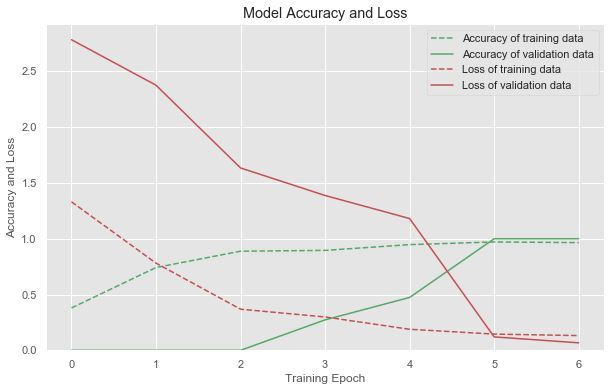

In [12]:
# The EarlyStopping callback monitors training accuracy:
# if it fails to improve for two consecutive epochs,
# training stops early
callbacks_list = [
    keras.callbacks.ModelCheckpoint(
        filepath='best_model.{epoch:02d}-{val_loss:.2f}.h5',
        monitor='val_loss', save_best_only=True),
    keras.callbacks.EarlyStopping(monitor='acc', patience=1)
]

model_m.compile(loss='categorical_crossentropy',
                optimizer='adam', metrics=['accuracy'])

# Hyper-parameters
BATCH_SIZE = 30
EPOCHS = 50

# Enable validation to use ModelCheckpoint and EarlyStopping callbacks.
history = model_m.fit(x_train,
                      y_train,
                      batch_size=BATCH_SIZE,
                      epochs=EPOCHS,
                      callbacks=callbacks_list,
                      validation_split=0.2,
                      verbose=1)
print("\n--- Training Successfully completed !!! \n")


# summarize history for accuracy and loss
plt.figure(figsize=(10, 6))
plt.plot(history.history['acc'], "g--", label="Accuracy of training data")
plt.plot(history.history['val_acc'], "g", label="Accuracy of validation data")
plt.plot(history.history['loss'], "r--", label="Loss of training data")
plt.plot(history.history['val_loss'], "r", label="Loss of validation data")
plt.title('Model Accuracy and Loss')
plt.ylabel('Accuracy and Loss')
plt.xlabel('Training Epoch')
plt.ylim(0)
plt.legend()
plt.show()

In [13]:
# test with test data 
# Normalize features for testing data set just as we did for training set
# Load data set containing all the data from csv

df_test = pd.read_csv('4pump_classes.csv')

# Describe the data
show_basic_dataframe_info(df_test, 10000) #show first 20 rows of the data


Number of columns in the dataframe: 2
Number of rows in the dataframe: 41745

First 20 rows of the dataframe:

         CONDITION  x-axis
0     contaminated    -0.6
1     contaminated    -5.8
2     contaminated    -9.4
3     contaminated   -11.9
4     contaminated   -13.8
...            ...     ...
9995  contaminated    -0.0
9996  contaminated     0.1
9997  contaminated    -0.0
9998  contaminated     0.2
9999  contaminated    -0.0

[10000 rows x 2 columns]

Description of dataframe:



In [15]:
df_test['x-axis'] = feature_normalize(df_test['x-axis'])  #normalise the x-axis signals (testing)
df_test = df_test.round({'x-axis': 6})

# Define column name of the label vector for converting to numbers
LABEL = "CONDITION"
# Transform the labels from String to Integer via LabelEncoder
le = preprocessing.LabelEncoder()
# Add a new column to the existing DataFrame with the encoded values
df_test[LABEL] = le.fit_transform(df_test["CONDITION"].values.ravel())
df_test
#df_train[:40000]

#CONTAMINATED = 0
#FILTER CLOG  = 1
#HEALTHY      = 2
#HIGH VISC    = 3

# Normalize features for training data set
df_test['x-axis'] = feature_normalize(df_test['x-axis'])

x_test, y_test = create_segments_and_labels(df_test, TIME_PERIODS, STEP_DISTANCE, LABEL)

# Set input_shape / reshape for Keras
x_test = x_test.reshape(x_test.shape[0], input_shape)

x_test = x_test.astype("float32")
y_test = y_test.astype("float32")

y_test = np_utils.to_categorical(y_test, num_classes)

#y_predict = model.fit
score = model_m.evaluate(x_test, y_test, verbose=1)

print("\nAccuracy on test data: %0.2f" % score[1])
print("\nLoss on test data: %0.2f" % score[0])

1042/1042 [==============================] - 1s 819us/step

Accuracy on test data: 0.98

Loss on test data: 0.10


the shape of x_test is:  (1042, 80)
the shape of y_test is:  (1042, 4)
the shape of y_predict is:  (1042, 4)


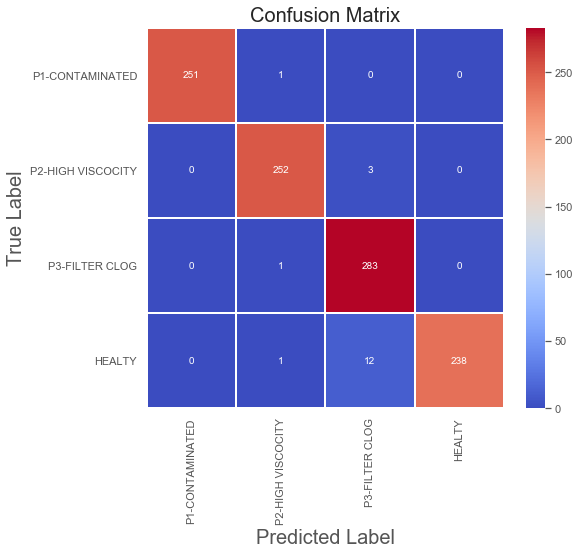

In [23]:
print('the shape of x_test is: ', x_test.shape)
print('the shape of y_test is: ', y_test.shape)

#confussion Matrix plot
y_pred_test = model_m.predict(x_test)
# Take the class with the highest probability from the test predictions
max_y_pred_test = np.argmax(y_pred_test, axis=1)
max_y_test = np.argmax(y_test, axis=1)

print('the shape of y_predict is: ', y_pred_test.shape)

show_confusion_matrix(max_y_test, max_y_pred_test)